Importing the necessary libraries and modules

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
import torch.utils.data as data
import math
import copy

In [2]:
torch.device('cuda')

device(type='cuda')

Multi-Head Attention


In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        # In this case, the softmax is applied along the last dimension of
        # the attn_scores tensor (dimension -1). This means that the softmax is
        # calculated independently for each position in the input sequence for each head.
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        # x.transpose(1, 2) swaps dimensions at positions 1 and 2, effectively undoing
        #  the transposition applied during the splitting step. This rearrangement aligns
        #  the dimensions back to their original order (batch_size, seq_length, num_heads, d_k).
        # .contiguous() ensures that the tensor is stored in a contiguous memory layout,
        # which is often necessary for certain tensor operations.
        # .view(batch_size, seq_length, self.d_model) reshapes the tensor into
        # the original model dimension, effectively combining the information from
        # the different attention heads. The resulting tensor has dimensions (batch_size, seq_length, d_model).
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        # Q: Query tensor with shape (batch_size, seq_length, d_model).
        # K: Key tensor with shape (batch_size, seq_length, d_model).
        # V: Value tensor with shape (batch_size, seq_length, d_model).
        # mask: An optional mask tensor with shape (batch_size, num_heads, seq_length, seq_length).

        # self.W_q(Q), self.W_k(K), and self.W_v(V) apply linear projections to
        # the queries, keys, and values tensors using the weight matrices W_q, W_k,
        # and W_v. These projections are applied to each token in the input sequence individually.
        # self.split_heads(...) is used to reshape the projected tensors into shapes
        # (batch_size, num_heads, seq_length, d_k), so that each head operates on a separate chunk of the data.
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)

        # self.W_o(...) is a linear projection applied to the combined attention output,
        # using the weight matrix W_o. This final projection transforms the
        # attention output into the same dimension as the input embeddings.
        output = self.W_o(self.combine_heads(attn_output))
        return output

Position-wise Feed-Forward Networks

In [4]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

Positional Encoding

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        # torch.arange(0, max_seq_length, dtype=torch.float): This function creates
        # a tensor containing values from 0 to max_seq_length - 1. The dtype=torch.float
        # argument ensures that the tensor has a floating-point data type.
        # .unsqueeze(1): This operation adds a new dimension to the tensor. Specifically,
        # it adds a new dimension at index 1, effectively transforming the tensor from
        # shape (max_seq_length,) to shape (max_seq_length, 1).
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # pe.unsqueeze(0): This creates a new tensor by adding a new dimension at
        # the beginning of the pe tensor. The shape of pe is (max_seq_length, d_model),
        # and after adding the unsqueezed dimension, the shape becomes (1, max_seq_length, d_model).
        # The purpose of registering the positional encoding tensor as a buffer is
        # to ensure that the tensor is properly handled by PyTorch's mechanisms for model state management,
        # device placement, and serialization. By registering the tensor as a buffer, PyTorch
        # will automatically move the tensor to the same device as the module's parameters
        # during training and inference. Additionally, the tensor will be saved and loaded
        # along with the module's state when saving and loading the model.
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

Encoder Layer

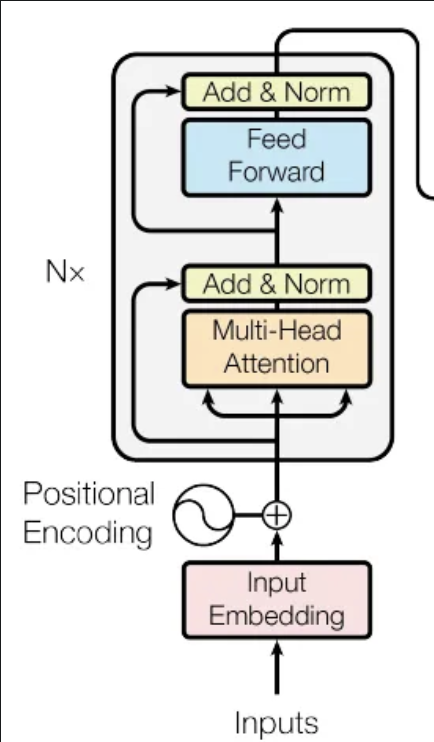

In [6]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

Decoder Layer

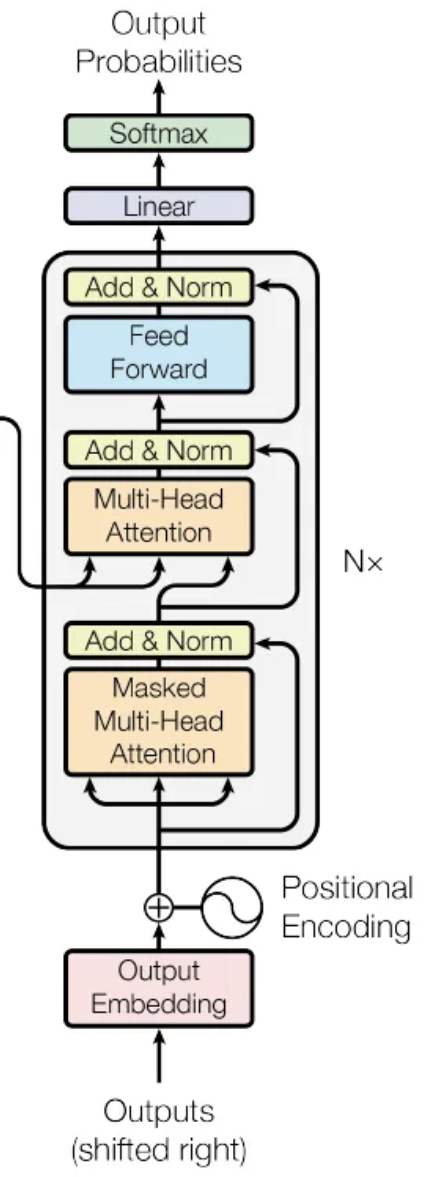

In [7]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

Transformer Model

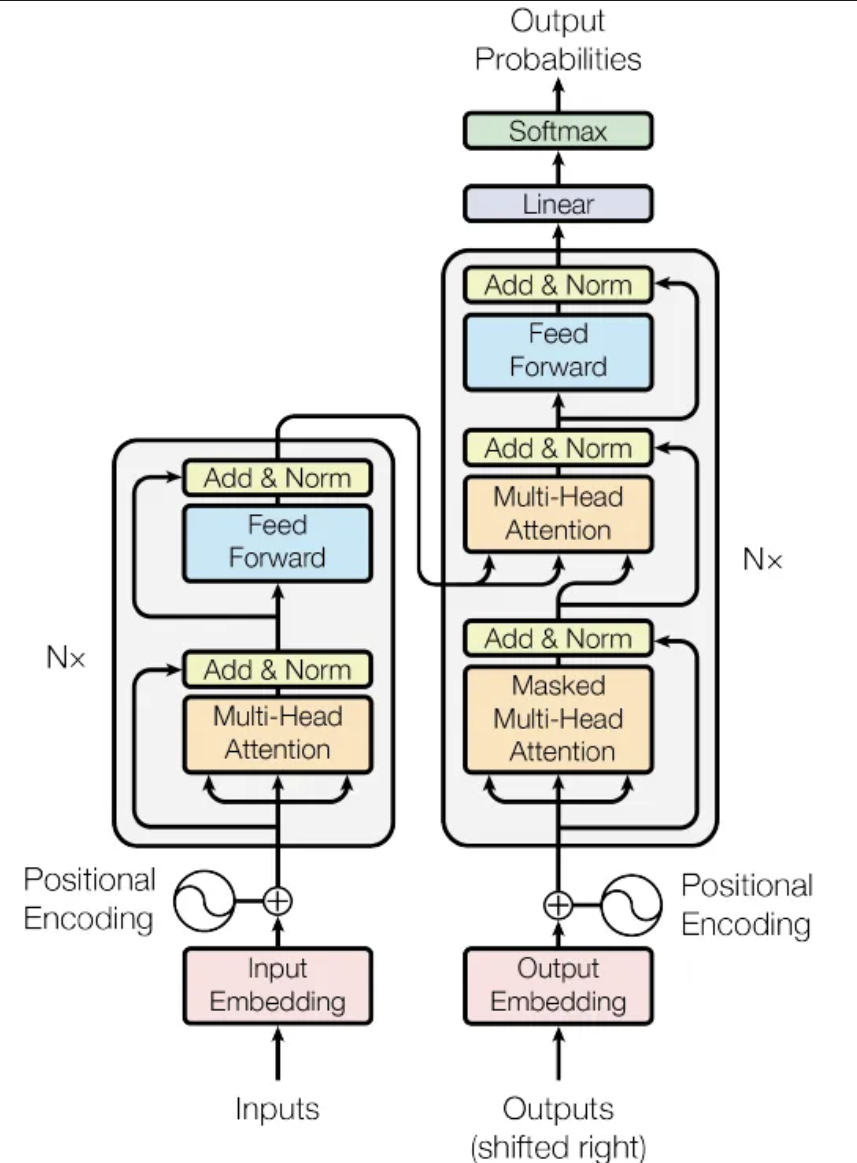

In [29]:
class Transformer(nn.Module):
    # src_vocab_size: Vocabulary size of the source language.
    # tgt_vocab_size: Vocabulary size of the target language.
    # d_model: The dimension of the model or embedding space.
    # num_heads: The number of attention heads in the multi-head attention mechanisms.
    # num_layers: The number of encoder and decoder layers in the model.
    # d_ff: The dimension of the hidden layer in the position-wise feedforward network.
    # max_seq_length: The maximum length of the input and target sequences.
    # dropout: The dropout probability to apply after various operations.
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        # nn.ModuleList is a container from the PyTorch library that holds a list of nn.Module instances.
        # This allows you to create and manage a list of layers or modules that constitute part of a larger neural network.
        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)


    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2).to('cuda')
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3).to('cuda')
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool().to('cuda')
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

Preparing Sample Data

In [30]:
src_vocab_size = 5000
tgt_vocab_size = 5000

# In the context of transformer-based models and the code you've provided,
# d_model refers to the dimension of the model's embedding space. It's a hyperparameter
# that defines the size of the continuous vector representations used to represent words
# or tokens in the model.
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = 100
dropout = 0.1

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)

# Generate random sample data
src_data = torch.randint(1, src_vocab_size, (64, max_seq_length)).to('cuda')  # (batch_size, seq_length)
tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length)).to('cuda')  # (batch_size, seq_length)

Using Pytorch Lightning

In [10]:
%%capture
!pip install pytorch-lightning

In [45]:
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl

class TransformerModel(pl.LightningModule):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout, learning_rate):
        super().__init__()
        self.save_hyperparameters()
        # Define your model components (similar to your Transformer class)
        self.transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)
        self.criterion = nn.CrossEntropyLoss(ignore_index=0)

    def forward(self, src, tgt):
        return self.transformer(src, tgt)

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer

    def training_step(self, batch, batch_idx):
        src_data, tgt_data = batch
        tgt_input = tgt_data[:, :-1]
        output = self(src_data, tgt_input)
        loss = self.criterion(output.contiguous().view(-1, self.hparams.tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def train_dataloader(self):
        # Create and return DataLoader for training data
        # You need to define src_data and tgt_data properly
        train_dataset = TensorDataset(src_data, tgt_data)
        return DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


Training the Model

In [46]:
# Step 1: Define Hyperparameters
epochs_num = 100
learning_rate = 0.0001
batch_size = 64  # Adjust as needed

# Step 2: Instantiate the Model
model = TransformerModel(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout, learning_rate)
model.to('cuda')
# Step 3: Instantiate the Trainer
trainer = pl.Trainer(max_epochs=epochs_num, accelerator="gpu", devices=1, log_every_n_steps=1)  # Adjust gpus parameter as needed

# Step 4: Fit the Model
trainer.fit(model)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type             | Params
-------------------------------------------------
0 | transformer | Transformer      | 51.8 M
1 | criterion   | CrossEntropyLoss | 0     
-------------------------------------------------
51.8 M    Trainable params
0         Non-trainable params
51.8 M    Total params
207.294   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


<h2>References</h2>
Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). Attention is all you need. Advances in neural information processing systems, 30.
<br>
https://towardsdatascience.com/all-you-need-to-know-about-attention-and-transformers-in-depth-understanding-part-1-552f0b41d021#62ce